In [9]:
#Keras Package
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Reshape, GRU, Input, RNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.utils import np_utils, plot_model
from keras.callbacks import EarlyStopping
#Numpy
import numpy as np
#Load Data
import h5py, glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
#Visualization
import matplotlib.pyplot as plt
#Timing
from time import time

In [2]:
#Import data
def import_data(filename):
    #Removes nan trial from imported data
    def remove_nan(X):
        idx = 0
        idx_nan = []
        for trial in X:
            if (np.isnan(trial).any()):
                print('Trial %d has nan' % idx)
                idx_nan.append(idx)
            idx += 1
        return np.delete(X,idx_nan,0), np.delete(y,idx_nan,0)

    #Load data
    A01T = h5py.File(filename, 'r')
    X = np.copy(A01T['image'])
    X = X[:,0:22,:] #remove EOG lines

    #769-left hand; 770-right hand; 771-both feet; 772-tongue
    y = np.copy(A01T['type'])
    y = y[0,0:X.shape[0]:1]
    y = np.asarray(y, dtype=np.int32)
    
    #Data Preprocess
    X, y = remove_nan(X) #Remove nans
    X = np.transpose(X,(0,2,1))
    X = np.expand_dims(X,3) #Expand dimension

    #Convert y to one-hot label
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    y = np_utils.to_categorical(encoded_y)
    num_classes = y.shape[1]

    #Check whole dimensions
    print(X.shape)
    print(y.shape)
    
    return X, y, num_classes

In [3]:
#Load files
files = glob.glob('project_datasets/*.mat')
subjects = -1
X = {}
y = {}
for file in files:
    subjects += 1
    print(subjects)
    X[str(subjects)], y[str(subjects)], num_classes = import_data(file)    

0
Trial 56 has nan
(287, 1000, 22, 1)
(287, 4)
1
Trial 237 has nan
Trial 284 has nan
(286, 1000, 22, 1)
(286, 4)
2
Trial 113 has nan
Trial 249 has nan
(286, 1000, 22, 1)
(286, 4)
3
Trial 144 has nan
Trial 145 has nan
Trial 146 has nan
Trial 179 has nan
(284, 1000, 22, 1)
(284, 4)
4
Trial 6 has nan
Trial 28 has nan
Trial 57 has nan
Trial 101 has nan
Trial 220 has nan
Trial 225 has nan
(282, 1000, 22, 1)
(282, 4)
5
Trial 97 has nan
Trial 115 has nan
Trial 140 has nan
(285, 1000, 22, 1)
(285, 4)
6
(288, 1000, 22, 1)
(288, 4)
7
Trial 58 has nan
Trial 81 has nan
Trial 124 has nan
Trial 151 has nan
Trial 178 has nan
Trial 275 has nan
(282, 1000, 22, 1)
(282, 4)
8
Trial 22 has nan
Trial 61 has nan
Trial 92 has nan
Trial 93 has nan
Trial 159 has nan
Trial 202 has nan
Trial 204 has nan
Trial 218 has nan
Trial 239 has nan
Trial 250 has nan
(278, 1000, 22, 1)
(278, 4)


In [4]:
# #Concatenate all data (for v2_bulk)
# t0 = time()
# X_net = X[str(0)];
# y_net = y[str(0)];
# for i in np.arange(1,len(X)):
#     X_net = np.concatenate((X_net,X[str(i)]),axis=0)
#     y_net = np.concatenate((y_net,y[str(i)]),axis=0)
# t1 = time()
# total = t1 - t0
# print("Time to concatenate = %f" % total)
# print()

#Creating Validation and Testing data
# X_train, X_test, y_train, y_test = train_test_split(X_net, y_net, test_size = 5/100, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 5/95, random_state=0)
# print(X_net.shape)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)
# print()
# print(y_net.shape)
# print(y_train.shape)
# print(y_val.shape)
# print(y_test.shape)

In [5]:
# #Concatenate all data (for v1_bulk)
idx = np.arange(len(X))
idx_train = idx[0:-2]
idx_val = idx[-2]
idx_test = idx[-1]
X_train, y_train = X[str(idx_train[0])], y[str(idx_train[0])]
X_val, y_val = X[str(idx_val)], y[str(idx_val)]
X_test, y_test = X[str(idx_test)], y[str(idx_test)]
for i in idx_train[1:]:
    X_train = np.concatenate((X_train,X[str(i)]),axis=0)
    y_train = np.concatenate((y_train,y[str(i)]),axis=0)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1998, 1000, 22, 1)
(282, 1000, 22, 1)
(278, 1000, 22, 1)

(1998, 4)
(282, 4)
(278, 4)


In [10]:
#Create Deep CNN
# Conv2D: (layer name, filter length, number of filters, stride size)
# GRU layers: (layer name, number of filters)
def create_rnn():
    activation = 'elu'
    input_shape = Input(shape = X['1'][0].shape)
    init = 'glorot_uniform'

    #Block 1
    cnn_1 = Conv2D(25, (10,1), kernel_initializer=init)(input_shape)
    cnn_1 = Conv2D(25, (1,22), kernel_initializer=init)(cnn_1)
    cnn_1 = BatchNormalization()(cnn_1)
    cnn_1 = Activation(activation)(cnn_1)
    cnn_1 = MaxPooling2D(pool_size=(3, 1), strides=3)(cnn_1)
    cnn_1 = Dropout(0.5)(cnn_1)

    #Block 2
    cnn_2 = Conv2D(50, (10,1), kernel_initializer=init)(cnn_1)
    cnn_2 = BatchNormalization()(cnn_2)
    cnn_2 = Activation(activation)(cnn_2)
    cnn_2 = MaxPooling2D(pool_size=(3, 1), strides=3)(cnn_2)
    cnn_2 = Dropout(0.5)(cnn_2)

    #Block 3
    cnn_3 = Conv2D(100, (10,1), kernel_initializer=init)(cnn_2)
    cnn_3 = BatchNormalization()(cnn_3)
    cnn_3 = Activation(activation)(cnn_3)
    cnn_3 = MaxPooling2D(pool_size=(3, 1), strides=3)(cnn_3)
    cnn_3 = Dropout(0.5)(cnn_3)

    #Block 4
    cnn_4 = Conv2D(200, (10,1), kernel_initializer=init)(cnn_3)
    cnn_4 = BatchNormalization()(cnn_4)
    cnn_4 = Activation(activation)(cnn_4)
    cnn_4 = MaxPooling2D(pool_size=(3, 1), strides=3)(cnn_4)
    cnn_4 = Dropout(0.5)(cnn_4)
    cnn_4 = Reshape((-1, 200))(cnn_4)

    #RNN Block
    gru_1 = GRU(200,return_sequences=True,dropout=0.1)(cnn_4)
    gru_2 = GRU(200,return_sequences=True,dropout=0.1)(gru_1)
    gru_output_1 = keras.layers.concatenate([gru_1, gru_2], axis = 2)

    gru_3 = GRU(200,return_sequences=True,dropout=0.1)(gru_output_1)
    gru_output_2 = keras.layers.concatenate([gru_1, gru_2, gru_3], axis = 2)
    gru_4 = GRU(200,dropout=0.1)(gru_output_2)
    
#     gru_1 = GRU(32,return_sequences=True,dropout=0.1)(cnn_4)
#     gru_2 = GRU(32,return_sequences=True,dropout=0.1)(gru_1)
#     gru_3 = GRU(32,return_sequences=True,dropout=0.1)(gru_2)
#     gru_4 = GRU(32,dropout=0.1)(gru_3)
    
    out = Dense(units=4, kernel_initializer=init)(gru_4)
    out = BatchNormalization()(out)
    out = Activation('softmax')(out)
    model = Model(inputs = input_shape, outputs = out)
    return model

In [11]:
i = 1
model = create_rnn()
for layers in model.layers:
    print('Layer %d:' % i, layers.name)
#     print(layers.__dict__)
    if(hasattr(layers,'kernel_initializer')):
        print(layers.kernel_initializer)
    print(layers.input_shape)
    print(layers.output_shape)
    print()
    i += 1

Layer 1: input_3
(None, 1000, 22, 1)
(None, 1000, 22, 1)

Layer 2: conv2d_11
(None, 1000, 22, 1)
(None, 991, 22, 25)

Layer 3: conv2d_12
(None, 991, 22, 25)
(None, 991, 1, 25)

Layer 4: batch_normalization_11
(None, 991, 1, 25)
(None, 991, 1, 25)

Layer 5: activation_11
(None, 991, 1, 25)
(None, 991, 1, 25)

Layer 6: max_pooling2d_9
(None, 991, 1, 25)
(None, 330, 1, 25)

Layer 7: dropout_9
(None, 330, 1, 25)
(None, 330, 1, 25)

Layer 8: conv2d_13
(None, 330, 1, 25)
(None, 321, 1, 50)

Layer 9: batch_normalization_12
(None, 321, 1, 50)
(None, 321, 1, 50)

Layer 10: activation_12
(None, 321, 1, 50)
(None, 321, 1, 50)

Layer 11: max_pooling2d_10
(None, 321, 1, 50)
(None, 107, 1, 50)

Layer 12: dropout_10
(None, 107, 1, 50)
(None, 107, 1, 50)

Layer 13: conv2d_14
(None, 107, 1, 50)
(None, 98, 1, 100)

Layer 14: batch_normalization_13
(None, 98, 1, 100)
(None, 98, 1, 100)

Layer 15: activation_13
(None, 98, 1, 100)
(None, 98, 1, 100)

Layer 16: max_pooling2d_11
(None, 98, 1, 100)
(None, 32,

Train on 1998 samples, validate on 282 samples
Epoch 1/60
1998/1998 [==============================] - 12s 6ms/step - loss: 1.4199 - acc: 0.2673 - val_loss: 1.4108 - val_acc: 0.2447
Epoch 2/60
1998/1998 [==============================] - 5s 2ms/step - loss: 1.3675 - acc: 0.3033 - val_loss: 1.4466 - val_acc: 0.2660
Epoch 3/60
1998/1998 [==============================] - 5s 2ms/step - loss: 1.3404 - acc: 0.3413 - val_loss: 1.4303 - val_acc: 0.2908
Epoch 4/60
1998/1998 [==============================] - 5s 2ms/step - loss: 1.3034 - acc: 0.3829 - val_loss: 1.3008 - val_acc: 0.3830
Epoch 5/60
1998/1998 [==============================] - 5s 2ms/step - loss: 1.2682 - acc: 0.4074 - val_loss: 1.2926 - val_acc: 0.3333
Epoch 6/60
1998/1998 [==============================] - 5s 2ms/step - loss: 1.2431 - acc: 0.4204 - val_loss: 1.2545 - val_acc: 0.3972
Epoch 7/60
1998/1998 [==============================] - 5s 2ms/step - loss: 1.2222 - acc: 0.4479 - val_loss: 1.4292 - val_acc: 0.3475
Epoch 8/60
199

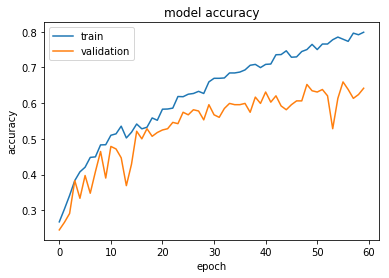

In [12]:
#Training
batch_size = 16
epochs = 60
opt = keras.optimizers.adam(lr=0.001)
results = []

model = create_rnn()
model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])
result = model.fit(X_train, y_train,
                   batch_size=batch_size,
                   validation_data=(X_val, y_val),
                   epochs=epochs)
results.append(result.history['val_acc'])

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
# Testing Accuracy
test_results = model.predict(x=X_test, batch_size=batch_size)
categ_results = np.argmax(test_results,axis=1)
categ_test = np.argmax(y_test,axis=1)
test_acc = np.sum(categ_results==categ_test)/len(categ_results)
print('Training Accuracy: %.3f' % result.history['acc'][-1])
print('Validation Accuracy: %.3f' % result.history['val_acc'][-1])
print('Testing Accuracy: %.3f' % test_acc)

Training Accuracy: 0.799
Validation Accuracy: 0.642
Testing Accuracy: 0.489
